<a href="https://colab.research.google.com/github/kemcen/AIF360/blob/master/msci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Genre Classification**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul 16 12:42:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install audiomentations
!pip install torch torchaudio torchvision
!pip install pyrubberband

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyrubberband: filename=pyrubberband-0.3.0-py3-none-any.whl size=4284 sha256=d4b508f8458cb63a2cf9f39e5b4db84ba788c53fba686a5250871dd44345760f
  Stored in directory: /root/.cache/pip/wheels/d7/e4/01/8590e5b5fb52cead6f5cc389449054af4423310e45ec34d74e
Successfully built pyrubberband


In [3]:
import numpy as np
import IPython.display as display
import librosa, librosa.display
import matplotlib.pyplot as plt
import os, glob
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from tqdm import tqdm
import random
import json
from sklearn.model_selection import train_test_split
from torch import nn
import tensorflow as tf
from sklearn.preprocessing import normalize
from keras import callbacks
import pyrubberband as pyrb

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/Data/genres_original

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [6]:
dir="/content/drive/MyDrive/Data/genres_original/"

In [7]:
genres = "blues classical country disco hiphop jazz	metal pop reggae rock".split()

### Example exercise


In [ ]:
example_file = "jazz.00055.wav"

example_dir = os.path.join(dir, "jazz/", example_file)
display.Audio(example_dir)

In [ ]:
# load audio file with Librosa
signalj, sample_ratej = librosa.load(example_dir)

print("Signal", signalj) # 2d array, first axis represents the recorded samples of amplitudes(change of air pressure) in the audio, second axis represents the number of channels in the audio.

print("SR:", sample_ratej) # returns how many samples are recorded per second

In [ ]:
y_shifted = librosa.effects.pitch_shift(signalj, sample_ratej, n_steps=4)
y_shifted2 = pyrb.pitch_shift(signalj, sample_ratej, n_steps=4, rbargs=None)
mfcc = librosa.feature.mfcc(signalj, sample_ratej)
mfcc_shifted = librosa.feature.mfcc(y_shifted, sample_ratej)
mfcc_shifted2 = librosa.feature.mfcc(y_shifted2, sample_ratej)

print(mfcc)
print(mfcc_shifted)
print(mfcc_shifted2)

RuntimeError: ignored

Text(0.5, 1.0, 'Waveform')

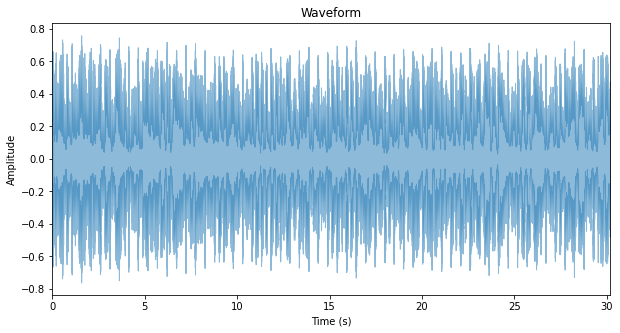

In [ ]:
plt.figure(figsize=(10,5))
librosa.display.waveplot(signal, sample_rate, alpha=0.5) # alpha for transparency
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Waveform gives us the amplitude moving in time. However, we want to move from time domain to the frequency domain. This is achieved by Fourier Transform. In time domain, the sound is visualized as an amplitude, as a function of time, we see all the events across time for the sound. Weheras, in frequency domain, we just look at all the frequency components of a sound and we see how much they contribute to the overall sound (x-axis Hz, y-axis Magnitude). We cant move directly from time doamin to frequency domain due to a major issue called spectral leakage. Spectral leakage happens when we are processing a signal that isn't an integre number of periods. Endpoints are discontinuous. If we have discontinuities, they get translated into the frequency domain as high-frequency components, which don't exist in the original signal. Tehy are just kind of artifact that appears because of the discontinuities at the end points of the signal that we are processing with the fourier transform. We can overcome this by windowing. Windowing is applying windowing function to each frame before we feed the frames into the FT. By doing so, we eliminate the samples at the end points of the frame, remove information from the endpoint, which generates a periodic signal which minimizes spectral leakage. Hann window can be used.

In [ ]:
# fourier transform - frequency domain
fft = np.fft.fft(signal)

In [ ]:
# calculate the magnitude
magnitude = np.abs(fft) # returns the absolute value of a number

In [ ]:
# frequency variable
w = np.linspace(0, sample_rate, len(magnitude))

Text(0.5, 1.0, 'FFT Spectrum')

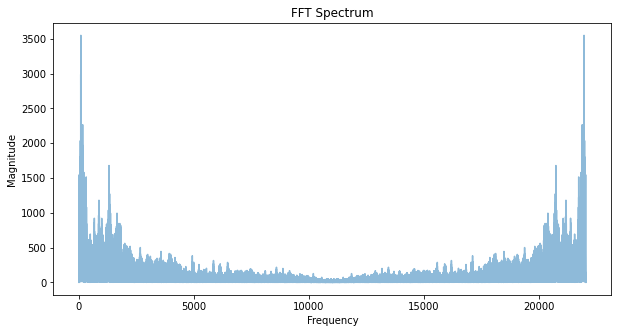

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(w, magnitude, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("FFT Spectrum")

We want to know how the magnitude changes considering some time windows. To do this we do not have to use FFT, we can use STFT. The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows. 

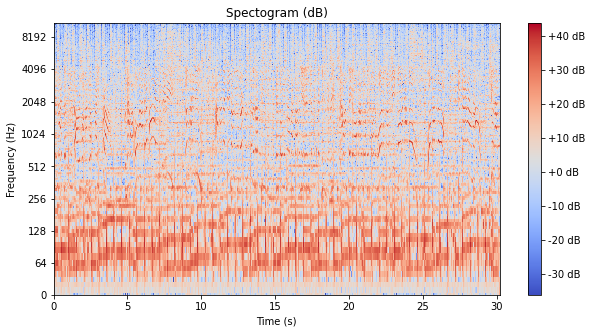

In [ ]:
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(signal))), x_axis='time', y_axis='log')
plt.title("Spectogram (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")
plt.show()

### Feature Extraction

audiomentations library is an easy-to-use tool that allows us to augment audio files in various ways.

In [8]:
# data augmentation
add_noise = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)])
time_stretch = Compose([TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)])
pitch_shift = Compose([PitchShift(min_semitones=-4, max_semitones=4, p=0.5)])

In [9]:
#Spectogram features
n_mels = 128
hop_length = 512 # number of samples
n_fft = 2048 # number of samples for window

# extract melspec features
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# convert to DB scale and display the spectogram
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(signal))), x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB');

NameError: ignored

Preparing data

In [8]:
JSON_PATH = 'data.json'

# Sampling rate.
SAMPLE_RATE = 22050

TRACK_DURATION = 28 # measured in seconds
TOTAL_SAMPLES = TRACK_DURATION * SAMPLE_RATE

# X amount of slices => X times more training examples.
NUM_SEGMENTS = 5
SAMPLES_PER_SEGMENT = int(TOTAL_SAMPLES / NUM_SEGMENTS)

In [11]:
def augment_data(signal, sample_rate=SAMPLE_RATE):
  augmented_samples = list()

  augmented_samples.append(signal)

  for n_steps in [4,6]:
    augmented_samples.append(librosa.effects.pitch_shift(signal, sample_rate, n_steps=n_steps))

  for rate in [2.0]:
    augmented_samples.append(librosa.effects.time_stretch(signal, rate))

  return augmented_samples

In [12]:
def get_melspec(signal, sample_rate = SAMPLE_RATE, num_mfcc=13, n_fft = 2048, hop_length = 512):
    
    #y_shifted = librosa.effects.pitch_shift(signal, sample_rate, n_steps=4)

    #calculate the melspectogram of the audio wave
    for d in range(NUM_SEGMENTS):
      start = SAMPLES_PER_SEGMENT * d
      finish = start + SAMPLES_PER_SEGMENT

      # extract mfcc
      mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
      #mfcc_shifted = librosa.feature.mfcc(y_shifted[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
      spect = librosa.power_to_db(mfcc, ref=1.0)
      #spect_shifted = librosa.power_to_db(mfcc_shifted, ref=1.0)
      norm_spect = normalize(spect)
      #norm_spect2 = normalize(spect_shifted)
    return norm_spect

In [13]:
def prepare_data(main_path, folders, json_path):
  data = []
  label = []

  mydict = {
        "labels": [],
        "mfcc": []
        }
  i=0
  for folder in folders:
    print(f"Reading {folder}")
    files = os.listdir(main_path+'/'+folder)
    for audio_file in files:
      # make sure the file is a .wav file
      if audio_file.split('.')[-1] == 'wav':
        path = main_path+folder+'/'+audio_file
        # load original file
        signal, sample_rate = librosa.load(main_path+folder+'/'+audio_file, sr=SAMPLE_RATE)
        aug_samples = augment_data(signal, sample_rate)
        for sample_ in aug_samples:
          mfcc = get_melspec(sample_)
        # for s in range(NUM_SEGMENTS):
        #   start_sample = SAMPLES_PER_SEGMENT * s
        #   end_sample = start_sample + SAMPLES_PER_SEGMENT
        #   mfcc = librosa.feature.mfcc(y=signal[start_sample:end_sample], sr=SAMPLE_RATE, n_mfcc=13)
        #   mfcc = mfcc.T
          try:
            # data.append(mfcc)
            # label.append(folder)
            mydict["labels"].append(folder)
            mydict["mfcc"].append(mfcc.tolist())
            i+=1
          except:
            print("Error in file", path)
            pass
  X = np.array(mydict["mfcc"])
  y = np.array(mydict["labels"])
  return X, y

In [14]:
X, y = prepare_data(dir, genres, JSON_PATH)

Reading blues
Reading classical
Reading country
Reading disco
Reading hiphop
Reading jazz
Reading metal
Reading pop
Reading reggae
Reading rock


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
len(X)

4000

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

## CNN

In [17]:
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [18]:
print(f'Train: {X_train.shape} {y_train.shape}')
print(f'Test: {X_test.shape} {y_test.shape}')
print(f'Validation: {X_validation.shape} {y_validation.shape}')

Train: (2560, 13, 1) (2560,)
Test: (800, 13, 1) (800,)
Validation: (640, 13, 1) (640,)


In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train).reshape([len(y_train), 1])

encoder.fit(y_test)
y_test = encoder.transform(y_test).reshape([len(y_test), 1])

encoder.fit(y_validation)
y_val = encoder.transform(y_validation).reshape([len(y_validation), 1])

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2],1)

In [20]:
print(f'Train: {X_train.shape} {y_train.shape}')
print(f'Test: {X_test.shape} {y_test.shape}')

Train: (2560, 13, 1) (2560, 1)
Test: (800, 13, 1) (800, 1)


In [ ]:
# X, y = prepare_data(dir, genres)

In [ ]:
# audio_train, audio_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

In [ ]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

In [ ]:
def get_melspec(signal, sample_rate = SAMPLE_RATE, num_mfcc=13, n_fft = 2048, hop_length = 512, num_segments=5):
    #calculate the melspectogram of the provided audio wave
    for d in range(NUM_SEGMENTS):
      start = SAMPLES_PER_SEGMENT * d
      finish = start + SAMPLES_PER_SEGMENT

      # extract mfcc
      mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length) 
      mfcc_DB = librosa.power_to_db(mfcc, ref=np.max)
    return mfcc

In [ ]:
# def create_dataset(audio_train, audio_test):
#   X_train, Y_train = [], []
#   X_test, Y_test = [], []

#   for i, dat in tqdm(enumerate(audio_train)):

#     #add noise
#     #noise = add_noise(dat, SAMPLE_RATE)
#     add_noise = add_white_noise(dat, 0.05)

#     #time stretch
#     time = time_stretch(dat, SAMPLE_RATE)

#     #pitch shift
#     pitch = pitch_shift(dat, SAMPLE_RATE)

#     #get mel spec
#     mel = get_melspec(dat)
#     noise_mel = get_melspec(add_noise)
#     # timestretch_mel = get_melspec(time)
#     # pitch_mel = get_melspec(pitch)

#     #append augmented data to list
#     X_train.append(mel)
#     Y_train.append(y_train[i])
#     X_train.append(noise_mel)
#     Y_train.append(y_train[i])
#     # X_train.append(timestretch_mel)
#     # Y_train.append(y_train[i])
#     # X_train.append(pitch_mel)
#     # Y_train.append(y_train[i])

#   for i, dat in tqdm(enumerate(audio_test)):
#     #get mel spec
#     mel = get_melspec(dat)

#     #append test melspec to list
#     X_test.append(mel)
#     Y_test.append(y_test[i])
#   return X_train, y_train, X_test, y_test

In [23]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

IndexError: ignored

In [22]:
model = tf.keras.models.Sequential([
    
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.4),

        #final output layer with 10 predictions to be made
        tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

NameError: ignored

In [195]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 11, 240, 16)       160       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 6, 120, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_37 (Bat  (None, 6, 120, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_54 (Dropout)        (None, 6, 120, 16)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 4, 118, 8)         1160      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 2, 59, 8)       

In [196]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_val), batch_size=32, epochs=60, shuffle=True)

Epoch 1/60
80/80 [==============================] - 1s 6ms/step - loss: 2.7457 - accuracy: 0.1613 - val_loss: 2.4803 - val_accuracy: 0.0984
Epoch 2/60
80/80 [==============================] - 0s 4ms/step - loss: 2.2229 - accuracy: 0.2148 - val_loss: 2.9581 - val_accuracy: 0.1250
Epoch 3/60
80/80 [==============================] - 0s 4ms/step - loss: 2.1114 - accuracy: 0.2262 - val_loss: 3.5517 - val_accuracy: 0.1234
Epoch 4/60
80/80 [==============================] - 0s 4ms/step - loss: 2.0459 - accuracy: 0.2477 - val_loss: 3.5027 - val_accuracy: 0.0938
Epoch 5/60
80/80 [==============================] - 0s 4ms/step - loss: 2.0044 - accuracy: 0.2734 - val_loss: 3.0567 - val_accuracy: 0.1281
Epoch 6/60
80/80 [==============================] - 0s 4ms/step - loss: 1.9497 - accuracy: 0.2887 - val_loss: 3.0732 - val_accuracy: 0.1234
Epoch 7/60
80/80 [==============================] - 0s 4ms/step - loss: 1.9045 - accuracy: 0.3078 - val_loss: 2.4560 - val_accuracy: 0.1781
Epoch 8/60
80/80 [==

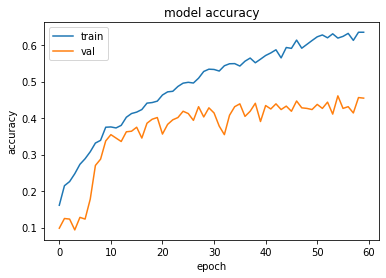

In [197]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

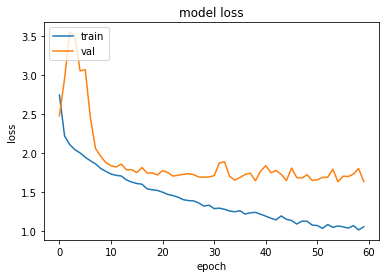

In [198]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [199]:
# evaluate model on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

25/25 - 0s - loss: 1.7230 - accuracy: 0.4600 - 56ms/epoch - 2ms/step

Test accuracy: 0.46000000834465027


### Predict on Test Set

In [149]:
# pick a sample to predict from the test set
X_to_predict = X_test[300]
y_to_predict = y_test[300]

In [150]:
X_to_predict.shape

(13, 242, 1)

In [151]:
print("Real Genre:", y_to_predict)

Real Genre: [4]


In [152]:
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)
X_to_predict.shape

(1, 13, 242, 1)

In [153]:
prediction = model.predict(X_to_predict)

In [154]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 4


In [141]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: [2]
Predicted Genre: 7

Real Genre: [9]
Predicted Genre: 0

Real Genre: [1]
Predicted Genre: 2

Real Genre: [1]
Predicted Genre: 1

Real Genre: [7]
Predicted Genre: 7

Real Genre: [2]
Predicted Genre: 8

Real Genre: [8]
Predicted Genre: 8

Real Genre: [8]
Predicted Genre: 8

Real Genre: [4]
Predicted Genre: 2

Real Genre: [1]
Predicted Genre: 1


## SVM